In [15]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval
import h5py 
from astropy.nddata import CCDData
import astropy.constants as const
from astropy.wcs import FITSFixedWarning
import warnings
warnings.simplefilter("ignore", category=FITSFixedWarning)
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter
from matplotlib import patches
from matplotlib.markers import MarkerStyle
import cmcrameri.cm as cmcm
import cmasher as cmr
from scipy import ndimage
from scipy.io import readsav
import copy
from juanfit import SpectrumFitSingle, SpectrumFitRow, gaussian
import skimage.draw

In [2]:
green_path = "../../src/EclipseSpectra2017/MikesData_l1/Green/"
red_path = "../../src/EclipseSpectra2017/MikesData_l1/Red/"

totality_green_im_collection = ImageFileCollection(green_path,
                        glob_include="TotalitySequence*.fit")
totality_green_df = totality_green_im_collection.summary.to_pandas()
totality_green_df["date-obs"] = pd.to_datetime(totality_green_df["date-obs"])

totality_green_df_cut = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,46,38)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_green_df_cut.sort_values(by="date-obs")
totality_green_df_cut = totality_green_df_cut.reset_index(drop=True)

totality_green_df_ext = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,8))]
totality_green_df_ext.sort_values(by="date-obs")                                        
totality_green_df_ext = totality_green_df_ext.reset_index(drop=True)

totality_red_im_collection = ImageFileCollection(red_path,
                        glob_include="TotalitySequence*.fit")
totality_red_df = totality_red_im_collection.summary.to_pandas()
totality_red_df["date-obs"] = pd.to_datetime(totality_red_df["date-obs"])

totality_red_df_cut = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,46,40)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_red_df_cut.sort_values(by="date-obs")
totality_red_df_cut = totality_red_df_cut.reset_index(drop=True)

totality_red_df_ext = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,2))]
totality_red_df_ext.sort_values(by="date-obs")
totality_red_df_ext = totality_red_df_ext.reset_index(drop=True)

In [3]:
FeXI_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXILine_ContRatio.fits",unit="adu")
FeXI_line_cont_image = FeXI_line_cont_frame.data
sun_center_FeXI = (np.float64(FeXI_line_cont_frame.header["SUNX"]),np.float64(FeXI_line_cont_frame.header["SUNY"]))
FeXI_line_cont_xslice = slice(372-300,372+301)
FeXI_line_cont_yslice = slice(383-220,383+221)
FeXI_line_cont_cutout = FeXI_line_cont_image[FeXI_line_cont_yslice, FeXI_line_cont_xslice]
FeXI_rotate_center = (sun_center_FeXI[0] - FeXI_line_cont_xslice.start, sun_center_FeXI[1] - FeXI_line_cont_yslice.start)
FeXI_line_cont_image_rot_scipy = ndimage.rotate(FeXI_line_cont_cutout, angle=360 - np.float64(FeXI_line_cont_frame.header["SUNROT"]),reshape=False,order=1)


FeXIV_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXIVLine_ContRatio.fits",unit="adu")
FeXIV_line_cont_image = FeXIV_line_cont_frame.data
sun_center_FeXIV = (np.float64(FeXIV_line_cont_frame.header["SUNX"]),np.float64(FeXIV_line_cont_frame.header["SUNY"]))
FeXIV_line_cont_xslice = slice(372-300,372+301)
FeXIV_line_cont_yslice = slice(383-220,383+221)
FeXIV_line_cont_cutout = FeXIV_line_cont_image[FeXIV_line_cont_yslice, FeXIV_line_cont_xslice]
FeXIV_rotate_center = (sun_center_FeXIV[0] - FeXIV_line_cont_xslice.start, sun_center_FeXIV[1] - FeXIV_line_cont_yslice.start)
FeXIV_line_cont_image_rot_scipy = ndimage.rotate(FeXIV_line_cont_cutout, angle=360 - np.float64(FeXIV_line_cont_frame.header["SUNROT"]),reshape=False,order=1)

In [4]:
with h5py.File("../../sav/Eclipse/LimbTrack/sun_pos_linear_fit.h5", 'r') as hf:
    sun_x_fitparam = hf['sun_x_fitparam'][:]
    sun_y_fitparam = hf['sun_y_fitparam'][:]

sun_x_fitpoly = np.poly1d(sun_x_fitparam)
sun_y_fitpoly = np.poly1d(sun_y_fitparam)

In [5]:
slit_pos = 209.4
rsun_arcsec = 950.0
rsun_context_pixel = 71.4
pixel_ratio = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])
img_pixel_to_arcsec = np.float64(FeXI_line_cont_frame.header["SUNR"])/rsun_arcsec
pixel_ratio_to_arcsec = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])*img_pixel_to_arcsec
rotate_angle_context = -27.5

eis_idl_sav = readsav("../../sav/EIS/EQSPY/EQSPY_lvl1_offset_170821_tilt_cor.sav",verbose=False)
eis_eqs_xcen, eis_eqs_ycen = np.array((eis_idl_sav["xcen"], eis_idl_sav["ycen_195"])) + eis_idl_sav["xy_correct_aia"]
eis_eqs_fovx, eis_eqs_fovy = np.array((eis_idl_sav["fovx"], eis_idl_sav["fovy"]))
eis_eqs_xstart = eis_eqs_xcen - eis_eqs_fovx/2.
eis_eqs_xend = eis_eqs_xcen + eis_eqs_fovx/2.
eis_eqs_ystart = eis_eqs_ycen - eis_eqs_fovy/2.
eis_eqs_yend = eis_eqs_ycen + eis_eqs_fovy/2.

In [6]:
green_frame_wavelength = CCDData.read(os.path.join(green_path,totality_green_df_cut.iloc[0]["file"]),hdu=1,unit="adu").data

with h5py.File("../../sav/Eclipse/FitResults/FeXIV_63.h5", 'r') as hf:
    green_fit_matrix_ext = hf['green_fit_matrix_ext'][:]
    green_fit_matrix_ext_err = hf['green_fit_matrix_ext_err'][:]
    green_fit_matrix_bin_ext = hf['green_fit_matrix_bin_ext'][:]
    green_fit_matrix_bin_ext_err = hf['green_fit_matrix_bin_ext_err'][:]
    green_fit_filename_index = hf['green_fit_filename_index'][:]
    green_fit_filename_index = hf['green_fit_filename_index'][:]

In [7]:
green_limb_loc = np.array([396.,625.,])
x_1d_grid_green_ext = np.arange(-63,125,1,dtype=np.float64)
y_1d_grid_green_ext = np.arange(np.mean(green_limb_loc) - 699.,  np.mean(green_limb_loc) - 349., 1, dtype=np.float64)

y_1d_grid_green_arcsec_ext = y_1d_grid_green_ext/(np.diff(green_limb_loc)/2.)*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
x_1d_grid_green_arcsec_ext = x_1d_grid_green_ext * (sun_x_fitpoly(10) - sun_x_fitpoly(9.5))/pixel_ratio_to_arcsec
y_1d_grid_green_arcsec_bin_ext = np.average(y_1d_grid_green_arcsec_ext.reshape(-1,5),axis=1)

x_2d_grid_green_arcsec_ext, y_2d_grid_green_arcsec_ext = np.meshgrid(x_1d_grid_green_arcsec_ext, y_1d_grid_green_arcsec_ext)
x_2d_grid_green_arcsec_bin_ext, y_2d_grid_green_arcsec_bin_ext = np.meshgrid(x_1d_grid_green_arcsec_ext, y_1d_grid_green_arcsec_bin_ext)

y_green_step_correction_ext = (sun_y_fitpoly(np.linspace(0,93.5,188)) - sun_y_fitpoly(62))/rsun_context_pixel*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
y_green_step_correction_ext = np.flip(y_green_step_correction_ext)

y_2d_grid_green_arcsec_correct_ext = y_2d_grid_green_arcsec_ext + y_green_step_correction_ext[np.newaxis,:]
y_2d_grid_green_arcsec_bin_correct_ext = y_2d_grid_green_arcsec_bin_ext + y_green_step_correction_ext[np.newaxis,:]

x_2d_grid_green_arcsec_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_correct_ext

y_2d_grid_green_arcsec_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_correct_ext

x_2d_grid_green_arcsec_bin_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_bin_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_bin_correct_ext

y_2d_grid_green_arcsec_bin_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_bin_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_bin_correct_ext

In [8]:
img_center = np.array([300,220])

def func_img_xpixel_to_xarcsec(x):
    return (x - img_center[0])/img_pixel_to_arcsec

def func_img_xarcsec_to_xpixel(x):
    return x*img_pixel_to_arcsec + img_center[0]

def func_img_ypixel_to_yarcsec(x):
    return (x - img_center[1])/img_pixel_to_arcsec

def func_img_yarcsec_to_ypixel(x):
    return x*img_pixel_to_arcsec + img_center[1]

def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [9]:
FeXIV_xslice = slice(345,395)
pixel_size_green = np.abs(np.mean(np.diff((green_frame_wavelength/63./10.)[FeXIV_xslice])))
inst_width_pix_green = 1.86
inst_width_nm_green = pixel_size_green*inst_width_pix_green

print(pixel_size_green, inst_width_nm_green)

0.024135148361387 0.04489137595217982


In [10]:
img_xpixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)

slit_xshift_green = sun_x_fitpoly(62) - slit_pos
slit_center_x_green =  - slit_xshift_green/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_green =  slit_xshift_green/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

In [11]:
green_where_disk_ext = np.where((x_2d_grid_green_arcsec_rot_ext + slit_center_x_green)**2 + \
                                    (y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)**2 < 940**2)

green_line_int_masked = np.copy(green_fit_matrix_ext[1,:,:])
green_line_int_masked[green_where_disk_ext] = np.nan

green_where_disk_bin_ext = np.where((x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green)**2 + \
                                    (y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green)**2 < 940**2)

green_vlos_masked = -(np.copy(green_fit_matrix_bin_ext[0,:,:]) - 530.29)/530.29*const.c.cgs.value*1e-5
green_vlos_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
green_vlos_masked[green_where_disk_bin_ext] = np.nan
green_vlos_masked = green_vlos_masked - np.nanmedian(green_vlos_masked)
green_vlos_masked_err = green_fit_matrix_bin_ext_err[0,:,:]/530.29*const.c.cgs.value*1e-5
green_vlos_masked_err[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
green_vlos_masked_err[green_where_disk_bin_ext] = np.nan

green_fwhm_masked = np.copy(green_fit_matrix_bin_ext[2,:,:])
green_fwhm_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
green_fwhm_masked[green_where_disk_bin_ext] = np.nan
green_fwhm_masked_err = np.copy(green_fit_matrix_bin_ext_err[2,:,:])
green_fwhm_masked_err[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
green_fwhm_masked_err[green_where_disk_bin_ext] = np.nan        
green_veff_masked = np.sqrt(green_fwhm_masked**2 - inst_width_nm_green**2)/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
green_veff_masked_err = green_fwhm_masked/np.sqrt(green_fwhm_masked**2 - inst_width_nm_green**2)* \
    green_fwhm_masked_err/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


In [13]:
def find_nearest_pixel(x,y,x_grid,y_grid):
    distance = np.sqrt((x - x_grid)**2 + (y - y_grid)**2)
    index = np.unravel_index(np.argmin(distance),distance.shape)
    return index

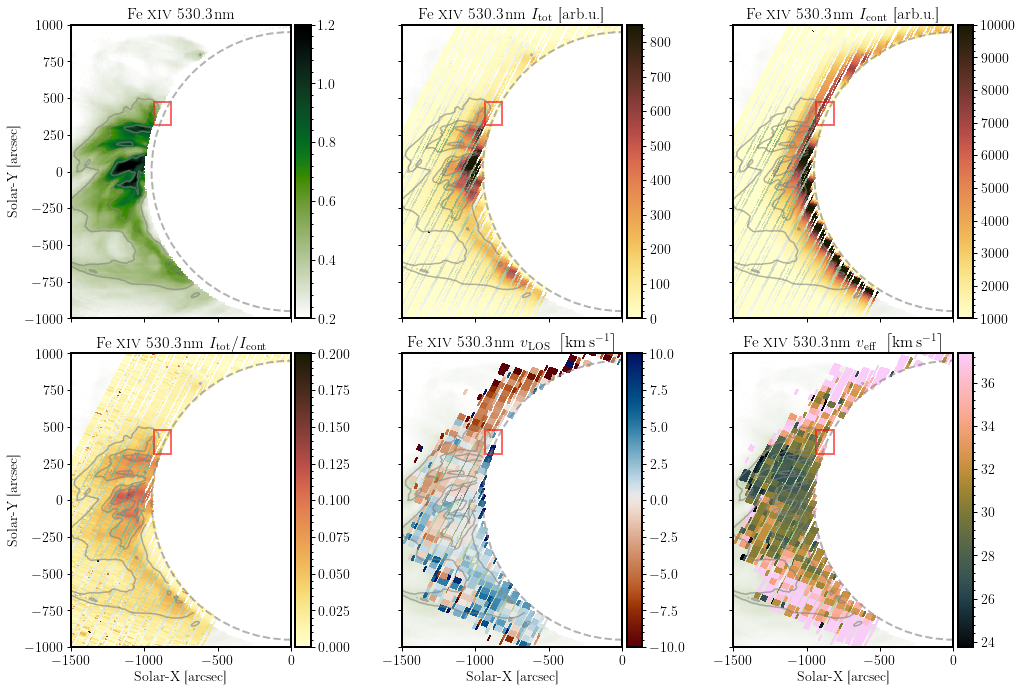

In [12]:
img_center = np.array([300,220])
img_xpixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)



colorbar_width = "7%"

def create_rec_eqs():
    return patches.Rectangle((eis_eqs_xstart, eis_eqs_ystart),
                            eis_eqs_fovx, eis_eqs_fovy,linewidth=2,edgecolor="red",
                            facecolor="none",alpha=0.6)

def create_limb_circle(rsun):
    return patches.Circle((0,0),rsun,linewidth=2,edgecolor="grey",
                            facecolor="none",alpha=0.6,ls="--")

slit_xshift_green = sun_x_fitpoly(62) - slit_pos
slit_center_x_green =  - slit_xshift_green/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_green =  slit_xshift_green/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(14,9.5),constrained_layout=True)
im1 = ax1.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,
                    cmap=cmr.jungle_r,shading="auto",rasterized=True)

plot_colorbar(im1, ax1,width=colorbar_width)

for ax_ in (ax2,ax3,ax4,ax5,ax6):
    ax_.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,
                    cmap=cmr.jungle_r,shading="auto",rasterized=True,alpha=0.5)

im2 = ax2.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_int_masked,cmap=cmcm.lajolla,rasterized=True,vmin=0,vmax=850)


plot_colorbar(im2, ax2,width=colorbar_width)

green_cont_masked = np.copy(green_fit_matrix_ext[3,:,:])
green_cont_masked[green_where_disk_ext] = np.nan
im3 = ax3.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_cont_masked,cmap=cmcm.lajolla,rasterized=True,vmin=1000,vmax=10000)

plot_colorbar(im3, ax3,width=colorbar_width)

green_line_cont_ratio_masked = green_fit_matrix_ext[1,:,:]/green_fit_matrix_ext[3,:,:]
green_line_cont_ratio_masked[green_where_disk_ext] = np.nan
im4 = ax4.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_cont_ratio_masked,cmap=cmcm.lajolla,rasterized=True,vmin=0,vmax=0.2)

plot_colorbar(im4, ax4,width=colorbar_width)

im5 = ax5.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                green_vlos_masked,cmap=cmcm.vik_r,rasterized=True,vmin=-10,vmax=10)

plot_colorbar(im5, ax5,width=colorbar_width)

im6 = ax6.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                green_veff_masked,cmap=cmcm.batlowK,rasterized=True,
                vmin=0.07/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
                ,vmax=0.11/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)))

plot_colorbar(im6, ax6,width=colorbar_width)

ax1.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax4.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax4.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax5.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax6.set_xlabel("Solar-X [arcsec]",fontsize=14)

ax1.set_title(r"Fe \textsc{xiv} 530.3\,nm",fontsize=16)
ax2.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm tot}$ [arb.u.]",fontsize=16)
ax3.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm cont}$ [arb.u.]",fontsize=16)
ax4.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm tot}/I_{\rm cont}$",fontsize=16)
ax5.set_title(r"Fe \textsc{xiv} 530.3\,nm $v_{\rm LOS}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16)
ax6.set_title(r"Fe \textsc{xiv} 530.3\,nm $v_{\rm eff}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16)

xlim_zoomin = [-1500,0]
ylim_zoomin = [-1000,1000]


for ax_ in (ax2,ax3,ax5,ax6):
    ax_.tick_params(labelleft=False)

for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelbottom=False)

for ax_ in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax_.contour(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,levels=[0.4,0.65,0.9],alpha=0.6,
            colors=['grey'])
    ax_.add_patch(create_rec_eqs())
    ax_.add_patch(create_limb_circle(rsun_arcsec))
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)
    ax_.set_xlim(xlim_zoomin)
    ax_.set_ylim(ylim_zoomin)

In [16]:
line_xcoord_solarx = np.array([-750,-1452])
line_ycoord_solary = np.array([-696,-684])
line_xcoord_pixel = np.zeros_like(line_xcoord_solarx)
line_ycoord_pixel = np.zeros_like(line_ycoord_solary)

for ii in range(len(line_xcoord_solarx)):
    line_ycoord_pixel[ii],line_xcoord_pixel[ii] = find_nearest_pixel(line_xcoord_solarx[ii],line_ycoord_solary[ii], 
        x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)
    
select_pixels_xindex = []
select_pixels_yindex = []

for ii in range(len(line_xcoord_pixel) - 1):
    rr, cc = skimage.draw.line(line_ycoord_pixel[ii],line_xcoord_pixel[ii],
                            line_ycoord_pixel[ii+1],line_xcoord_pixel[ii+1])
    
    select_pixels_xindex
    select_pixels_yindex.append(*rr)




TypeError: append() takes exactly one argument (86 given)